# Librerias

In [13]:
import dataAcquisition
import ReparameterizationTrick
import Encoder
import Decoder
import VAE
import loss
import train
import Predictor
import importlib
import numpy as np

#

# Data adquisition

In [14]:
importlib.reload(dataAcquisition)
#x_train, x_val, y_train, y_val, average_image_train, x_train_mixed, x_test_mixed, x_train_perm, y_train_perm

x_train, x_val, y_train, y_val, average_image, x_train_mix, x_test_mix,x_train_1, y_train_1 =  dataAcquisition.data_acquisition()

x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 28, 28)
x_val.shape:       (5000, 28, 28)
x_test.shape:       (10000, 28, 28)
x_train_mix.shape:  (55000, 28, 28)
x_test_mix.shape:  (10000, 28, 28)


# Encoder

In [15]:
importlib.reload(Encoder)
encoder = Encoder.encoder(x_train, y_train, latent_dim=128,intermediate_dim=256)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 784)       │          0 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 794)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ encoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    203,520 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 128)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 269,312 (1.03 MB)

 Trainable params: 269,312 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

# Decoder


In [16]:
importlib.reload(Decoder)
decoder = Decoder.decoder(x_train, y_train,latent_dim=128,intermediate_dim=128)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_sampling          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 138)       │          0 │ z_sampling[0][0], │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     17,792 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 784)       │    101,136 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,928 (464.56 KB)

 Trainable params: 118,928 (464.56 KB)

 Non-trainable params: 0 (0.00 B)

VAE

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 128),     │    269,312 │ input_img[0][0],  │
│ (Functional)        │ (None, 128),      │            │ encoder_conditio… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │    118,928 │ encoder[0][2],    │
│ (Functional)        │                   │            │ decoder_conditio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 388,240 (1.48 MB)

 Trainable params: 388,240 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

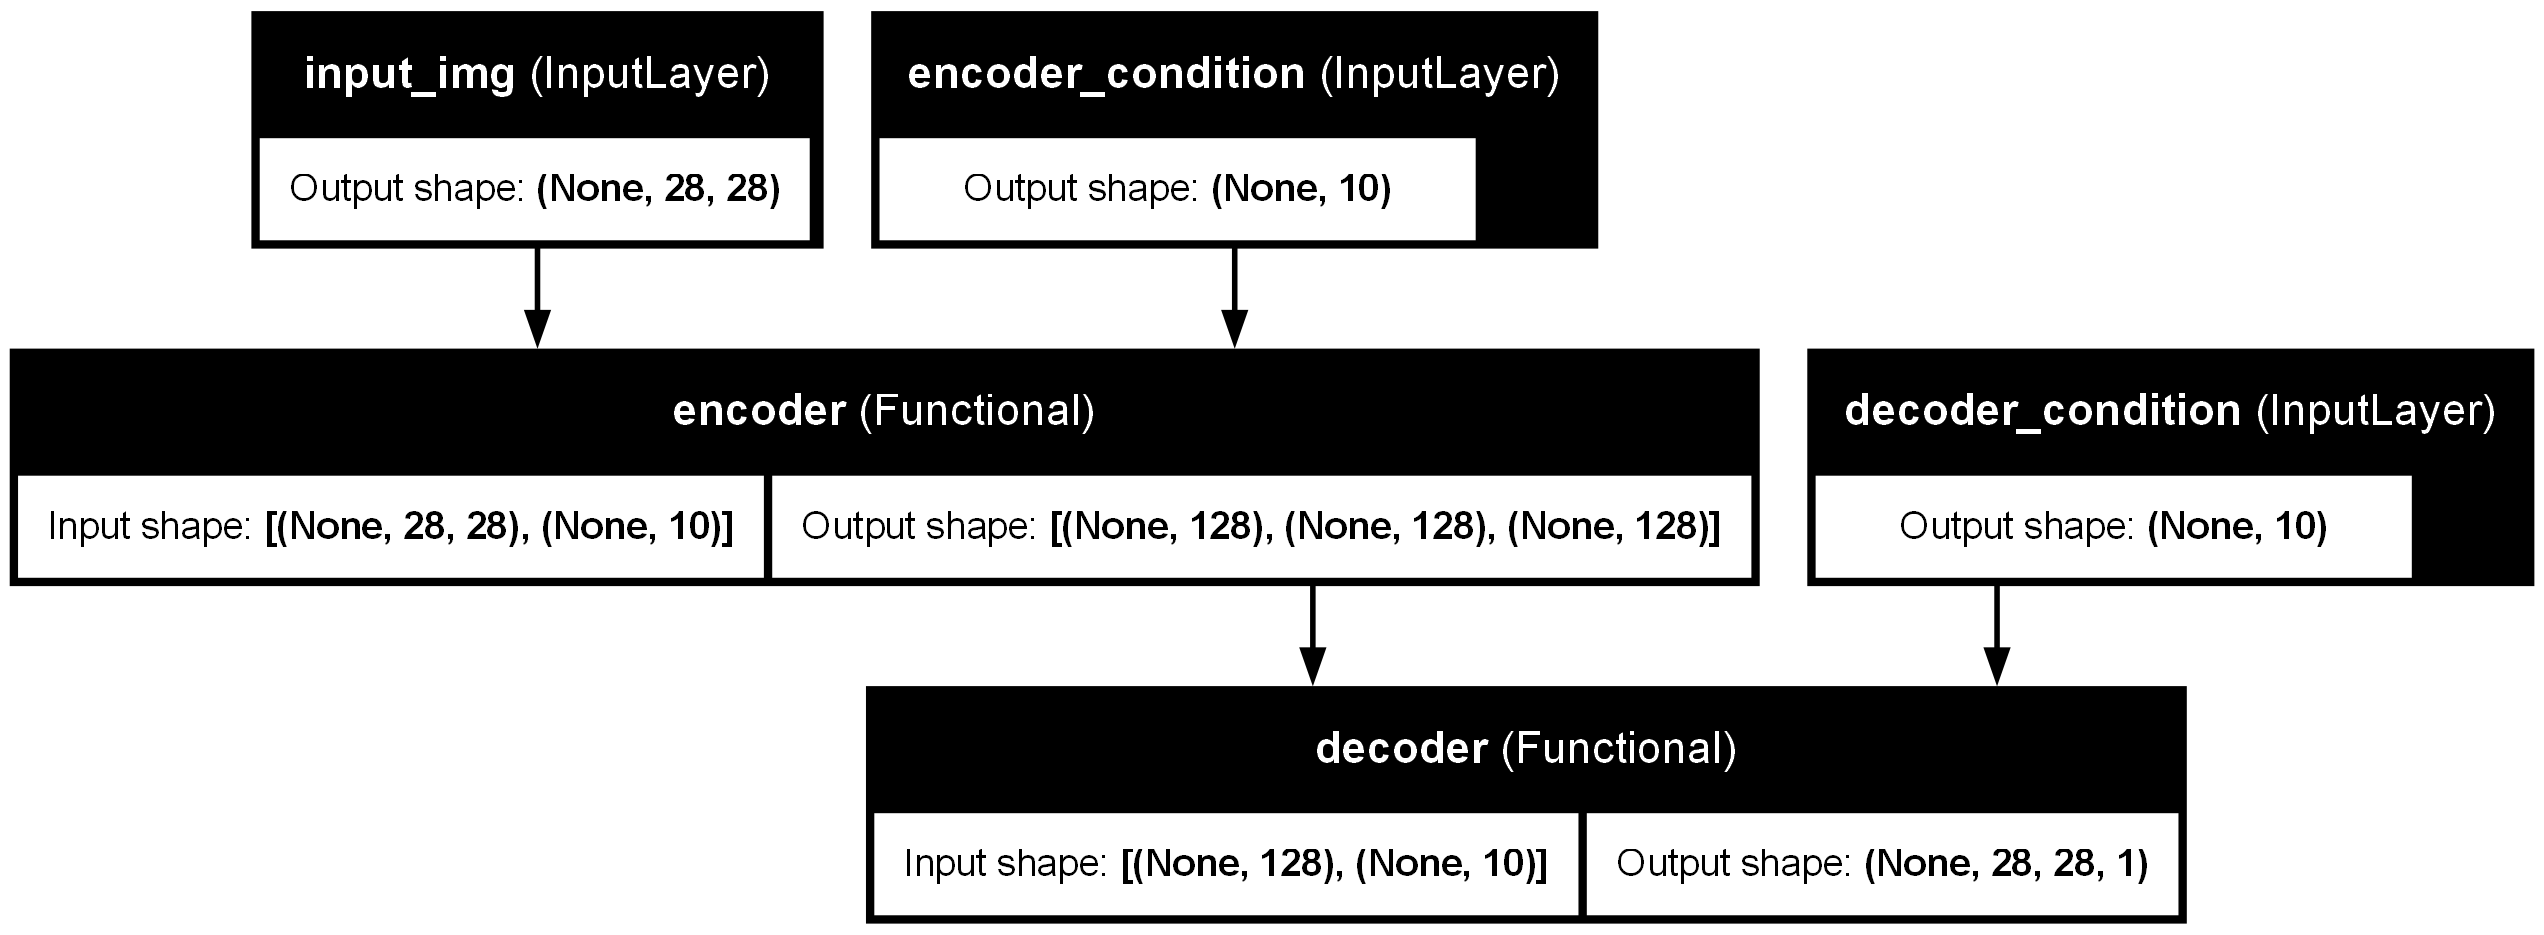

In [17]:
importlib.reload(VAE)
n_cond = np.shape(y_train)[1]  
vae =  VAE.Vae(encoder,decoder, show_model=True)

# Compile

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


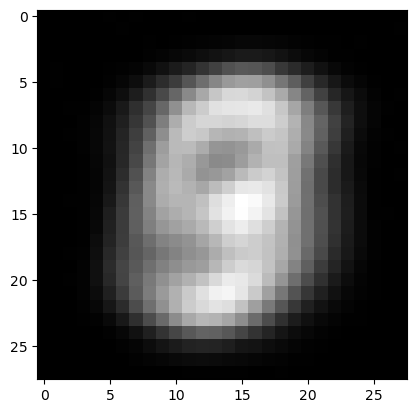

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(loss)
# Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=loss.vae_loss) #cambiar nombre

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

# Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2087 - val_loss: 0.1109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


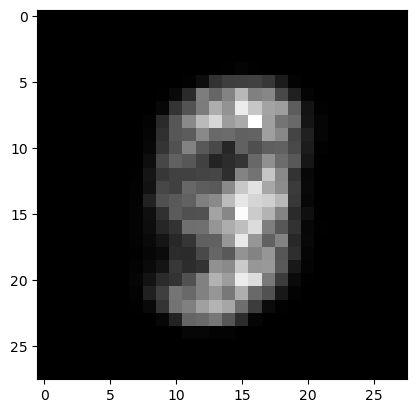

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1128 - val_loss: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


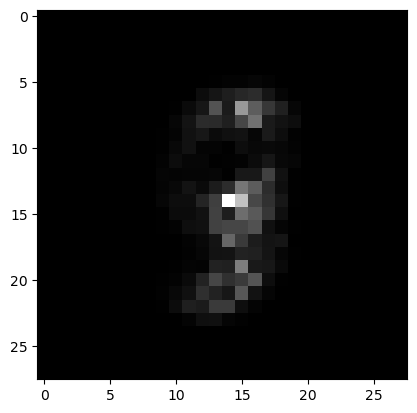

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1121 - val_loss: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


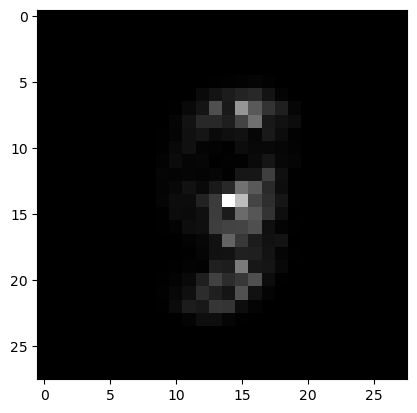

430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1119 - val_loss: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


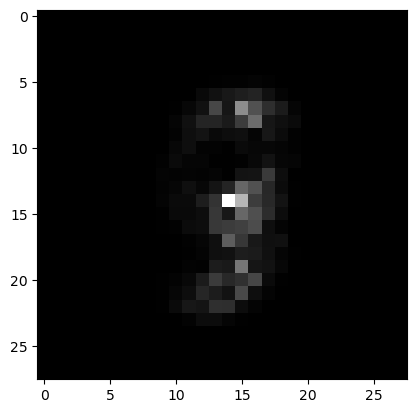

  7/430 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1137  

KeyboardInterrupt: 

In [27]:
salida = vae.predict([img, cond,cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

for i in range(20):
    train.train(vae, x_train, y_train, x_val, y_val)
    salida = vae.predict([img, cond,cond])
    reconstruccion = salida[0].reshape(28, 28)
    plt.imshow(reconstruccion, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


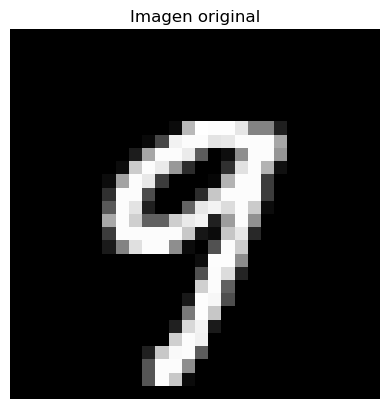

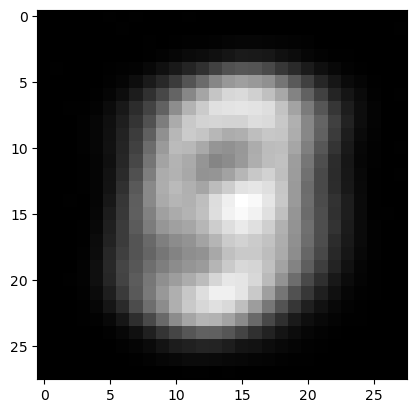

In [20]:
img = np.expand_dims(x_train[45], axis=0)
cond = np.expand_dims(y_train[45], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()
plt.imshow(reconstruccion, cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


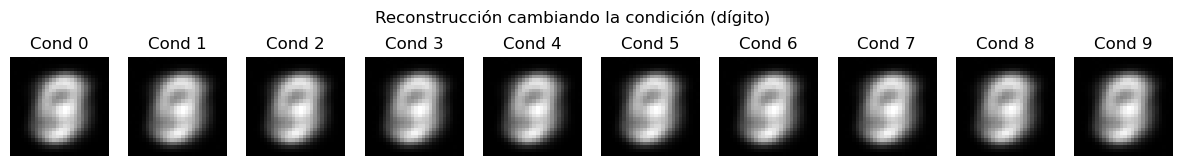

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona una imagen de prueba
img = np.expand_dims(x_train[0], axis=0)

plt.figure(figsize=(15, 2))
for i in range(10):
    # Crea la condición one-hot para el dígito i
    cond = np.zeros((1, 10))
    cond[0, i] = 1

    # Predice usando la misma condición para encoder y decoder
    salida = vae.predict([img, cond, cond])
    reconstruccion = salida[0].reshape(28, 28)

    plt.subplot(1, 10, i + 1)
    plt.imshow(reconstruccion, cmap='gray')
    plt.title(f"Cond {i}")
    plt.axis('off')

plt.suptitle("Reconstrucción cambiando la condición (dígito)")
plt.show()

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer_1 (ReshapeLayer)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

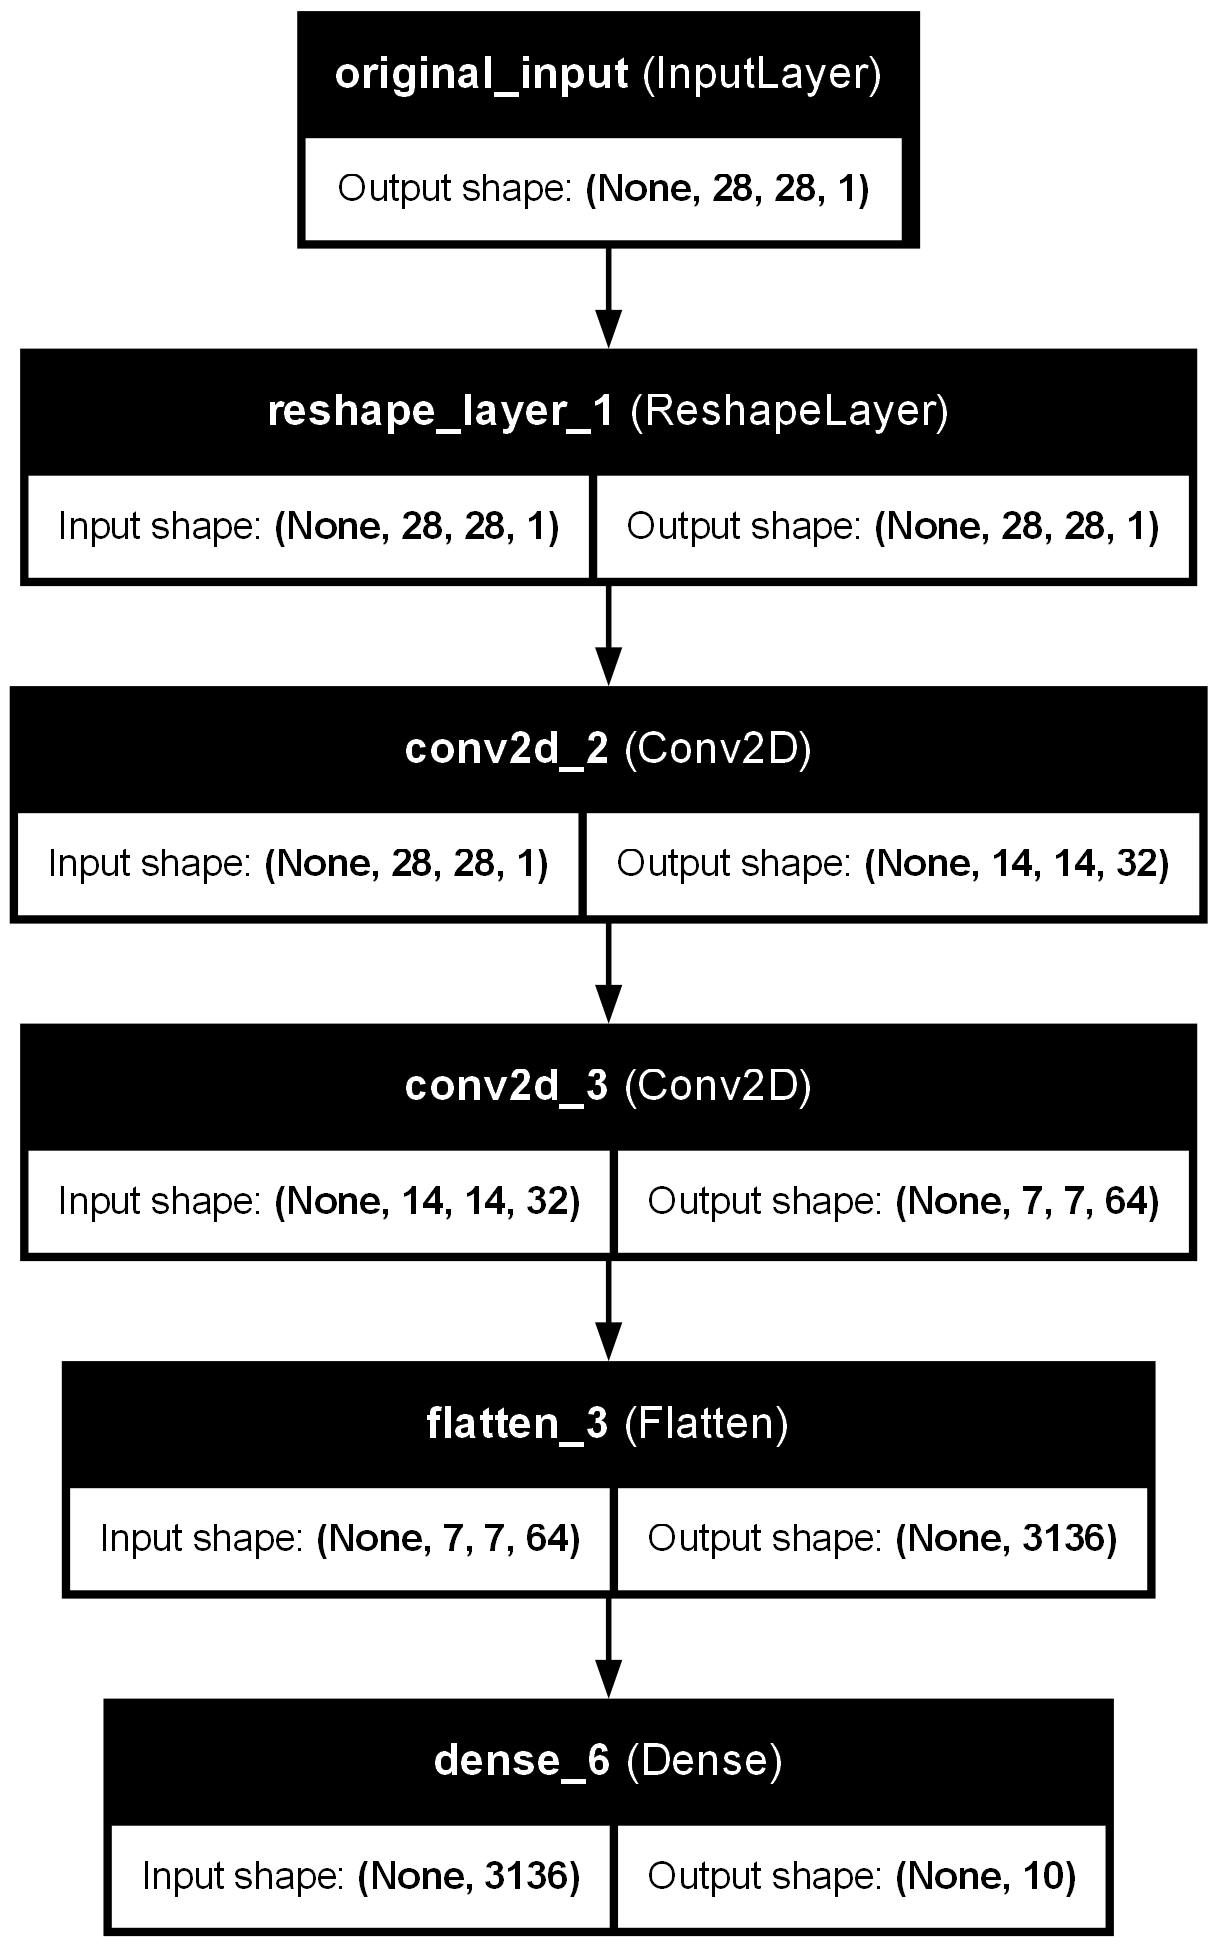

In [22]:
importlib.reload(Predictor)
predictor_c = Predictor.predictor()

(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


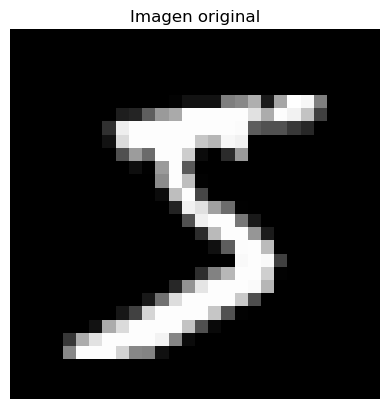

In [23]:
importlib.reload(Predictor)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
predictor_c.compile(optimizer, loss="categorical_crossentropy")
print(img.shape)
prediccion = np.argmax( predictor_c.predict(img))
img[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()


In [24]:
for i in range(20): 
    #reconstruccion = prediccion[0].reshape(28, 28)
    print(f"prediccion  {prediccion}")
    prediccion = np.argmax(predictor_c.predict(img))


    predictor_c.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=1,
        validation_data=(x_val, y_val)  # Include validation data
        )

prediccion  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.7129 - val_loss: 0.1251
prediccion  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1199 - val_loss: 0.0711
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0747 - val_loss: 0.0601
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0597 - val_loss: 0.0575
prediccion  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0470 - val_loss: 0.0599
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0412 - val_loss: 0.0539
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0330 - val_loss: 0.0518
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0284 - v

(55000, 28, 28)
(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
tf.Tensor(
[0.69976664 0.49413508 0.4508305  0.43724522 0.7969752  0.61895055
 0.26355165 0.71785426 0.29833946 0.5235839 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.35138226 0.4176984  0.70593876 0.70902056 0.38309452 0.5303649
 0.5386708  0.2878986  0.7929738  0.4848377 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.52557445 0.45591676 0.57838464 0.5731329  0.59003484 0.5746577
 0.40111122 0.5028764  0.5456566  0.5042108 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.6952482  0.4838016  0.44238767 0.43698105 0.7917719  0.6204951
 0.26209056 0.71605986 0.29858762 0.52239394], shape=(10,), dtype=float32)
tf.Tensor(
[0.34946087 0.41764408 0.7052593  0.70888156 0.38239762 0.52787924
 0.53511155 0.28885

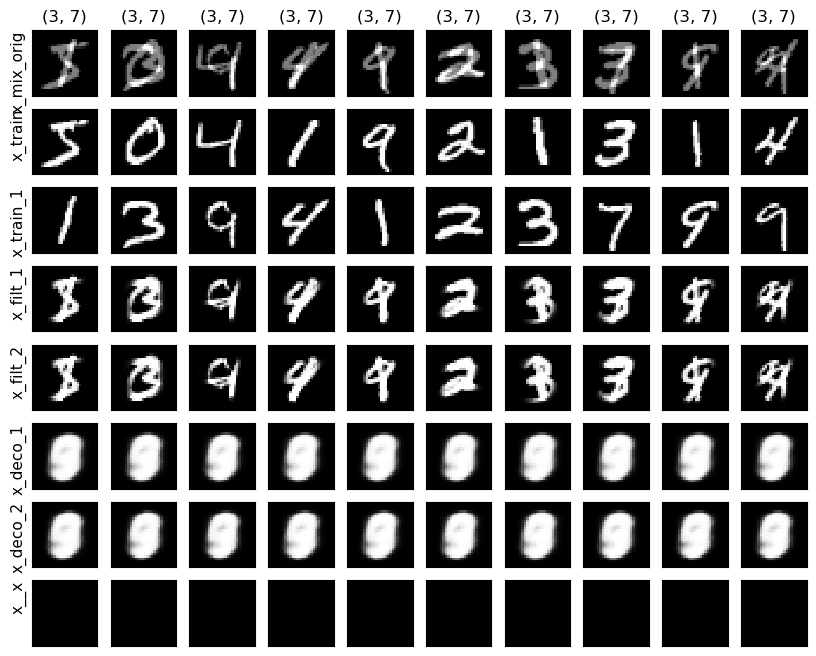

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
tf.Tensor(
[0.69619334 0.48406202 0.44182268 0.43622768 0.7961223  0.62082624
 0.26454496 0.71626484 0.29831386 0.52185446], shape=(10,), dtype=float32)
tf.Tensor(
[0.35101607 0.41872308 0.70627666 0.7122669  0.38292703 0.5314753
 0.5331681  0.2902071  0.79227906 0.48588434], shape=(10,), dtype=float32)
tf.Tensor(
[0.5236047  0.45139253 0.57404965 0.5742473  0.5895247  0.5761508
 0.39885652 0.50323594 0.54529643 0.5038694 ], shape=(10,), dtype=float32)
tf.Tensor(


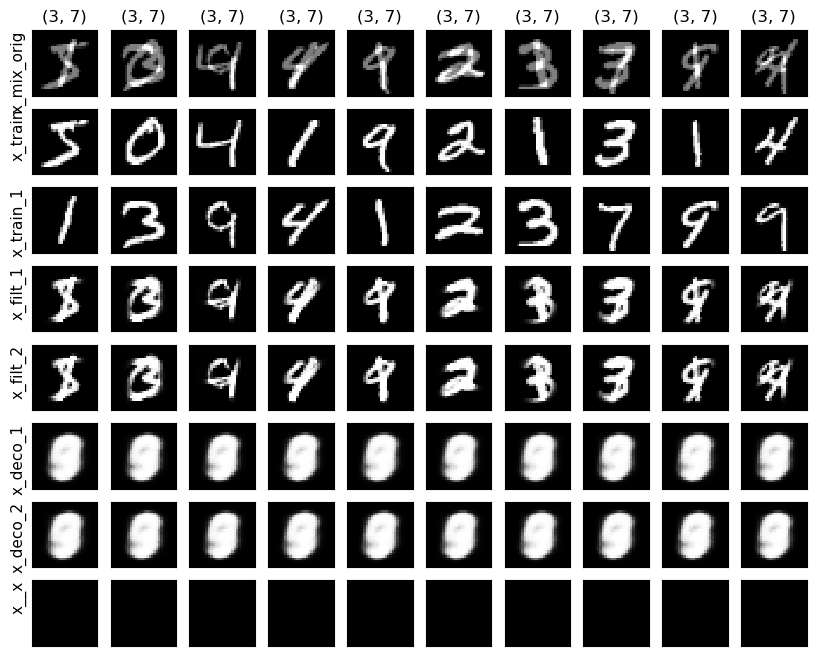

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
tf.Tensor(
[0.6968562  0.48558286 0.44195557 0.43657678 0.79278904 0.61851287
 0.26271668 0.71690726 0.29847255 0.5199903 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.35072052 0.41687182 0.70471144 0.7074708  0.38243344 0.5292126
 0.5363764  0.29080805 0.7962492  0.4851609 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.52378833 0.45122734 0.5733335  0.57202375 0.58761126 0.57386273
 0.39954656 0.5038577  0.5473609  0.50257564], shape=(10,), dtype=float32)
tf.Tensor(

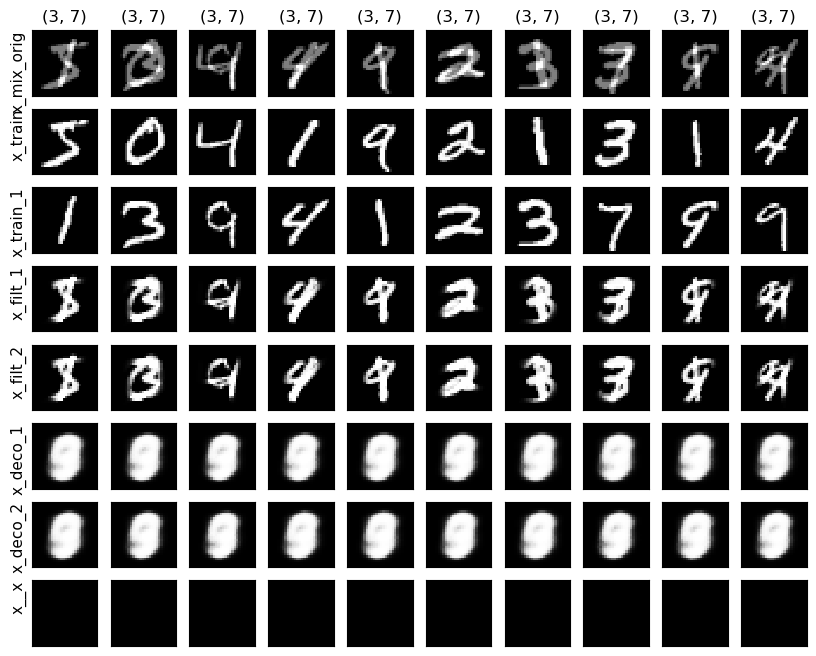

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
tf.Tensor(
[0.69778585 0.48445064 0.4419331  0.4371014  0.7924587  0.619754
 0.26212305 0.71439654 0.29866943 0.521387  ], shape=(10,), dtype=float32)
tf.Tensor(
[0.34908932 0.4165444  0.70763797 0.71036553 0.38265738 0.5208833
 0.5329991  0.28889593 0.79386103 0.48782793], shape=(10,), dtype=float32)
tf.Tensor(
[0.5234376  0.4504975  0.57478553 0.57373345 0.58755803 0.5703187
 0.39756107 0.5016462  0.54626524 0.50460744], shape=(10,), dtype=float32)
tf.Tensor(
[0

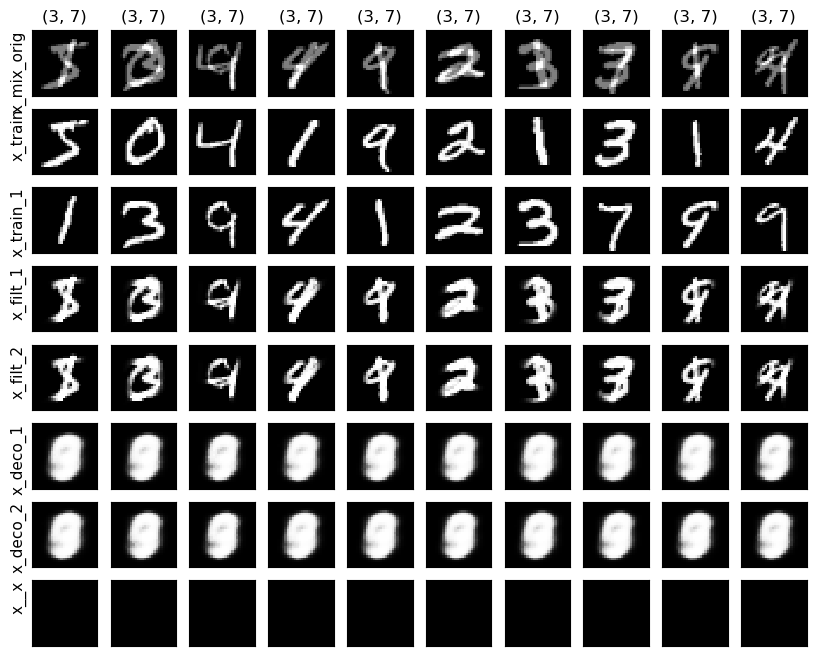

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tf.Tensor(
[0.69461435 0.4814733  0.44209167 0.4375504  0.7958171  0.6207602
 0.263142   0.7131462  0.29856762 0.5243871 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.3518295  0.41565004 0.7042182  0.7093134  0.38247183 0.526417
 0.538238   0.28949898 0.7933851  0.4860164 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.5232219  0.44856167 0.5731549  0.5734319  0.58914447 0.5735886
 0.40069    0.5013226  0.54597634 0.50520176], shape=(10,), dtype=float32)
tf.Tensor(
[0

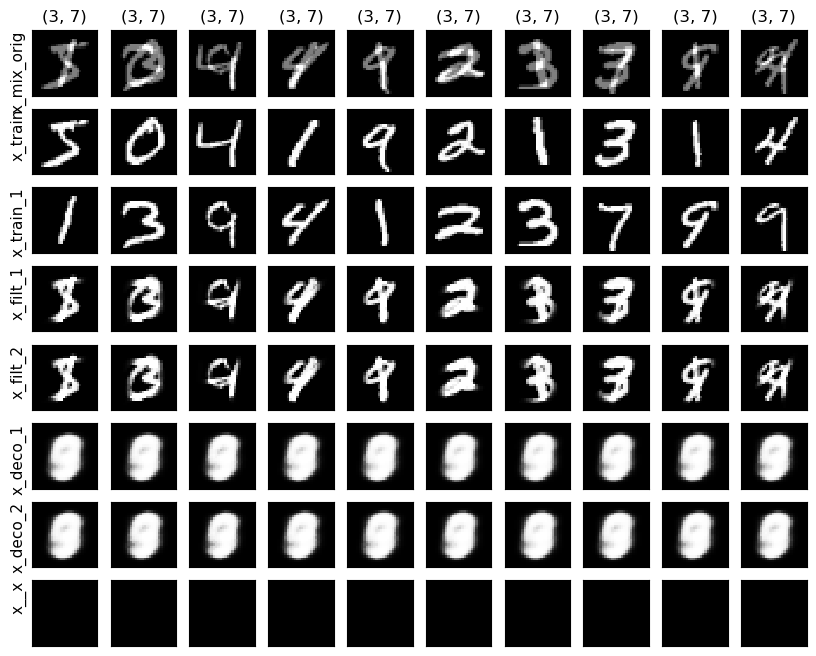

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tf.Tensor(
[0.6988368  0.4829583  0.4431692  0.43688494 0.7951291  0.61850125
 0.26263916 0.7121689  0.29863292 0.5210678 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.3498134  0.41677582 0.70682645 0.7066784  0.38249978 0.5283672
 0.53453016 0.2900028  0.79322684 0.48574933], shape=(10,), dtype=float32)
tf.Tensor(
[0.52432513 0.44986707 0.57499784 0.57178164 0.58881444 0.57343423
 0.39858466 0.5010858  0.5459299  0.50340855], shape=(10,), dtype=float32)
tf.Tensor(

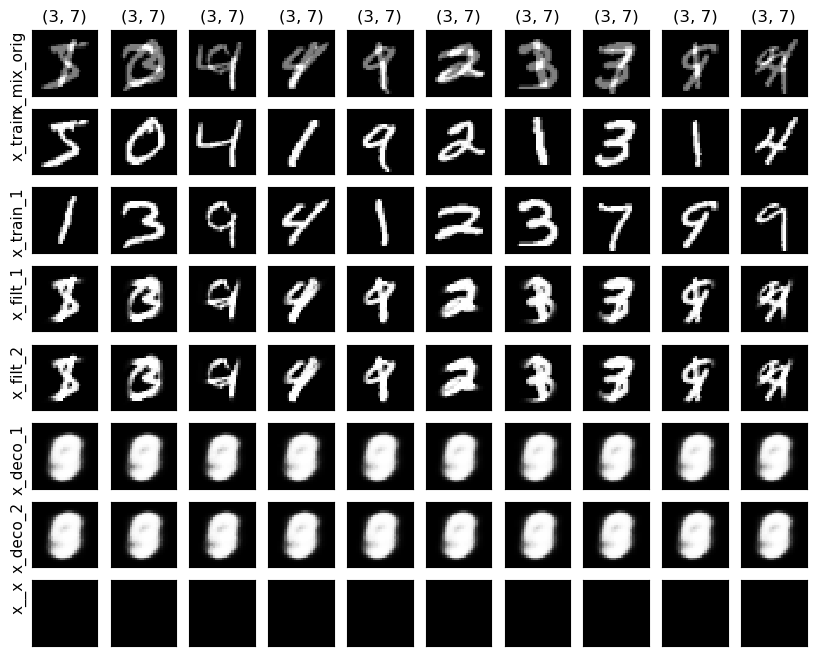

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tf.Tensor(
[0.6980524  0.48685035 0.4402634  0.43623757 0.7937136  0.621138
 0.26480028 0.71509385 0.29801452 0.5224665 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.35077575 0.4161721  0.70820487 0.708925   0.38241234 0.52773094
 0.5347004  0.2896616  0.7950662  0.4867095 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.52441406 0.4515112  0.5742341  0.5725813  0.588063   0.57443446
 0.39975035 0.50237775 0.5465404  0.504588  ], shape=(10,), dtype=float32)
tf.Tensor(


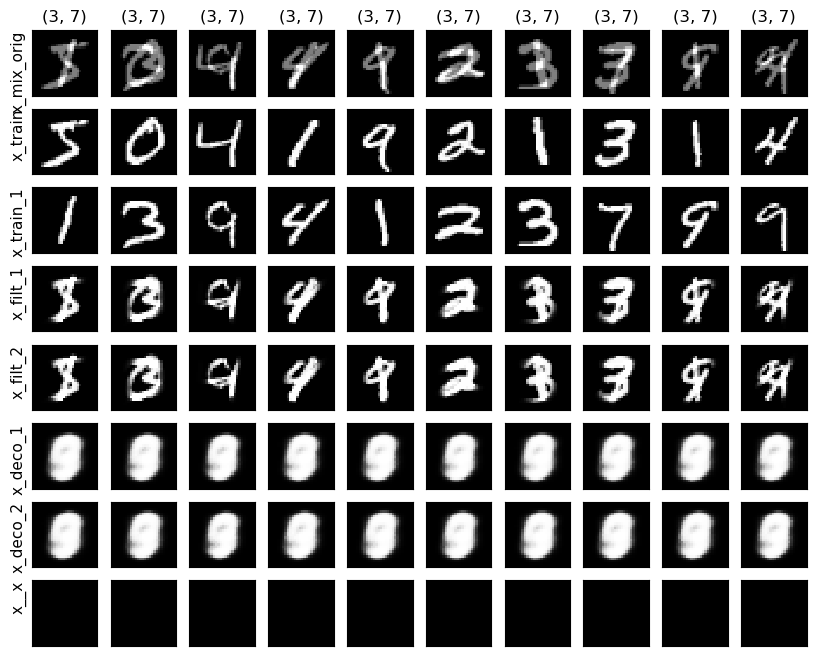

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
tf.Tensor(
[0.6991143  0.48846126 0.43982714 0.43616128 0.7950818  0.618998
 0.2641879  0.71511227 0.29825112 0.5230043 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.35083687 0.41687807 0.70870894 0.70651513 0.38218796 0.52194023
 0.535886   0.28784052 0.7956275  0.48563272], shape=(10,), dtype=float32)
tf.Tensor(
[0.5249756  0.45266968 0.57426804 0.5713382  0.58863485 0.57046914
 0.40003693 0.5014764  0.5469393  0.5043185 ], shape=(10,), dtype=float32)
tf.Tensor(


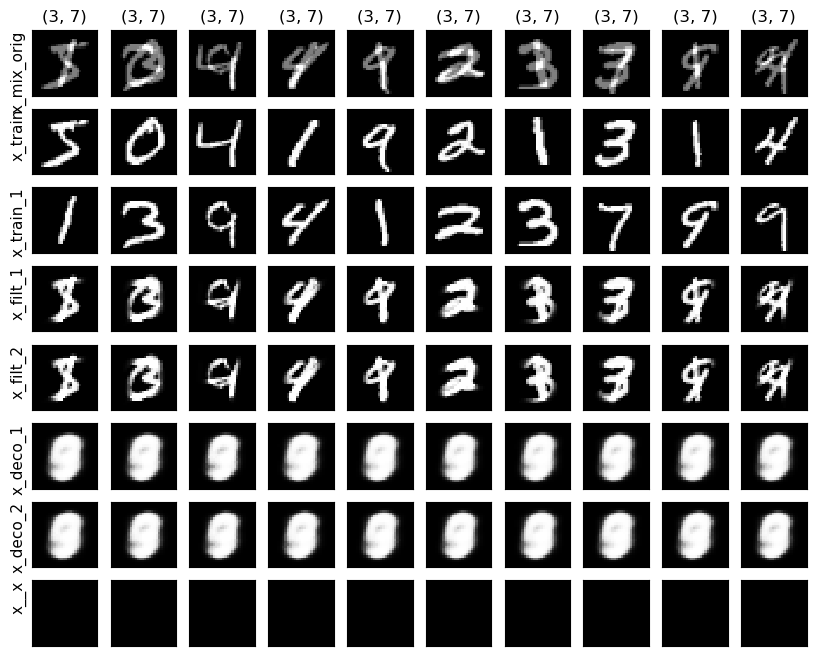

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tf.Tensor(
[0.6978302  0.48690927 0.44273508 0.43630868 0.791903   0.6196174
 0.26323888 0.7118365  0.29848704 0.5226868 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.35034233 0.41571143 0.70550394 0.7093671  0.38286892 0.52969503
 0.53531873 0.28898808 0.7953793  0.48448822], shape=(10,), dtype=float32)
tf.Tensor(
[0.52408624 0.45131034 0.5741195  0.5728379  0.58738595 0.57465625
 0.39927882 0.5004123  0.5469332  0.5035875 ], shape=(10,), dtype=float32)
tf.Tensor(

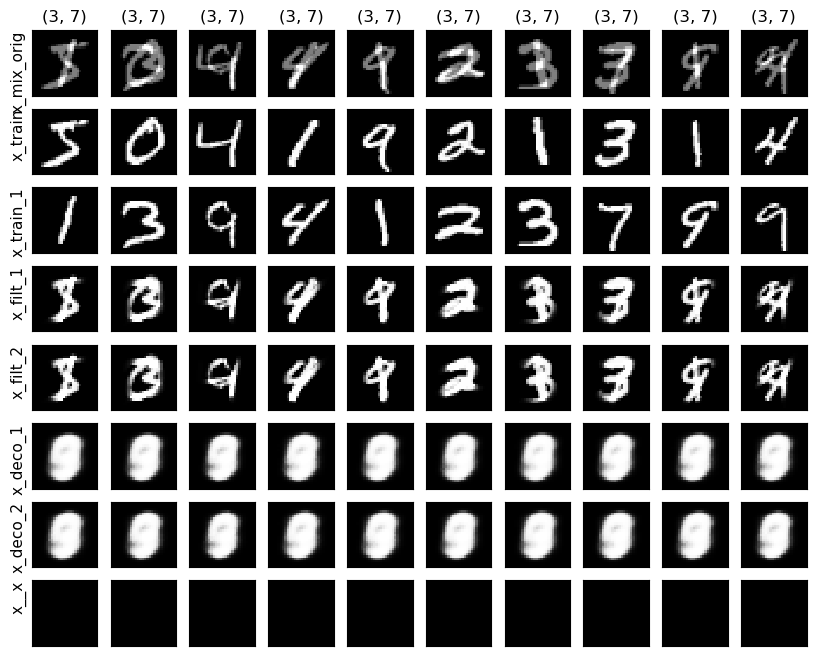

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
tf.Tensor(
[0.69556403 0.48016566 0.44208372 0.43656802 0.7950272  0.61905503
 0.2634987  0.7130391  0.29869458 0.5227759 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.34983557 0.41680607 0.70727026 0.71228904 0.38284045 0.53265077
 0.5340191  0.29159954 0.79537475 0.4816803 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.52269983 0.44848585 0.574677   0.57442856 0.5889338  0.5758529
 0.3987589  0.50231934 0.5470347  0.5022281 ], shape=(10,), dtype=float32)
tf.Tensor(

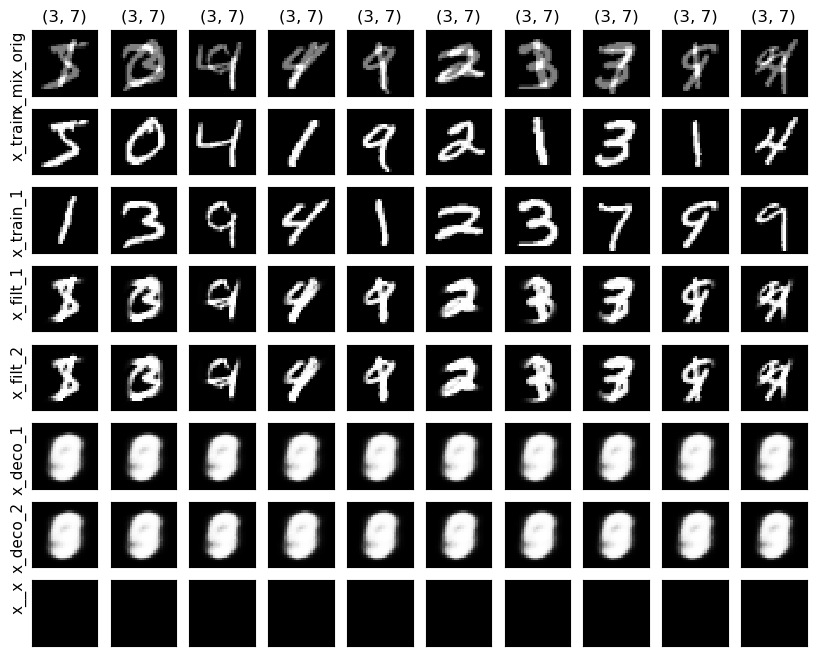

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.


In [25]:
import inferencias
importlib.reload(inferencias)
#importlib.reload(outcomes)
print(x_train.shape)
import inferencias
inicio=0
fin = inicio+ 10

# Suponiendo que ya tienes definidos:
# x_train, x_train_1, y_train, y_train_1, predictor, encoder, decoder

print(x_train[0:1].shape) #analizar por que se rompe con una sola imagen

inferencias.inferncia_modelo(x_train[inicio:fin], x_train_1[inicio:fin], y_train[inicio:fin], predictor_c, encoder, decoder, y_train_1[inicio:fin],vae)